In [1]:
import numpy as np
import matplotlib.pyplot as plt
import myPlot
import importlib
importlib.reload(myPlot)

<module 'myPlot' from '/Users/giulio/Desktop/tesi/git/dev/myPlot.py'>

Text(0.5, 0, 'Time (ms)')

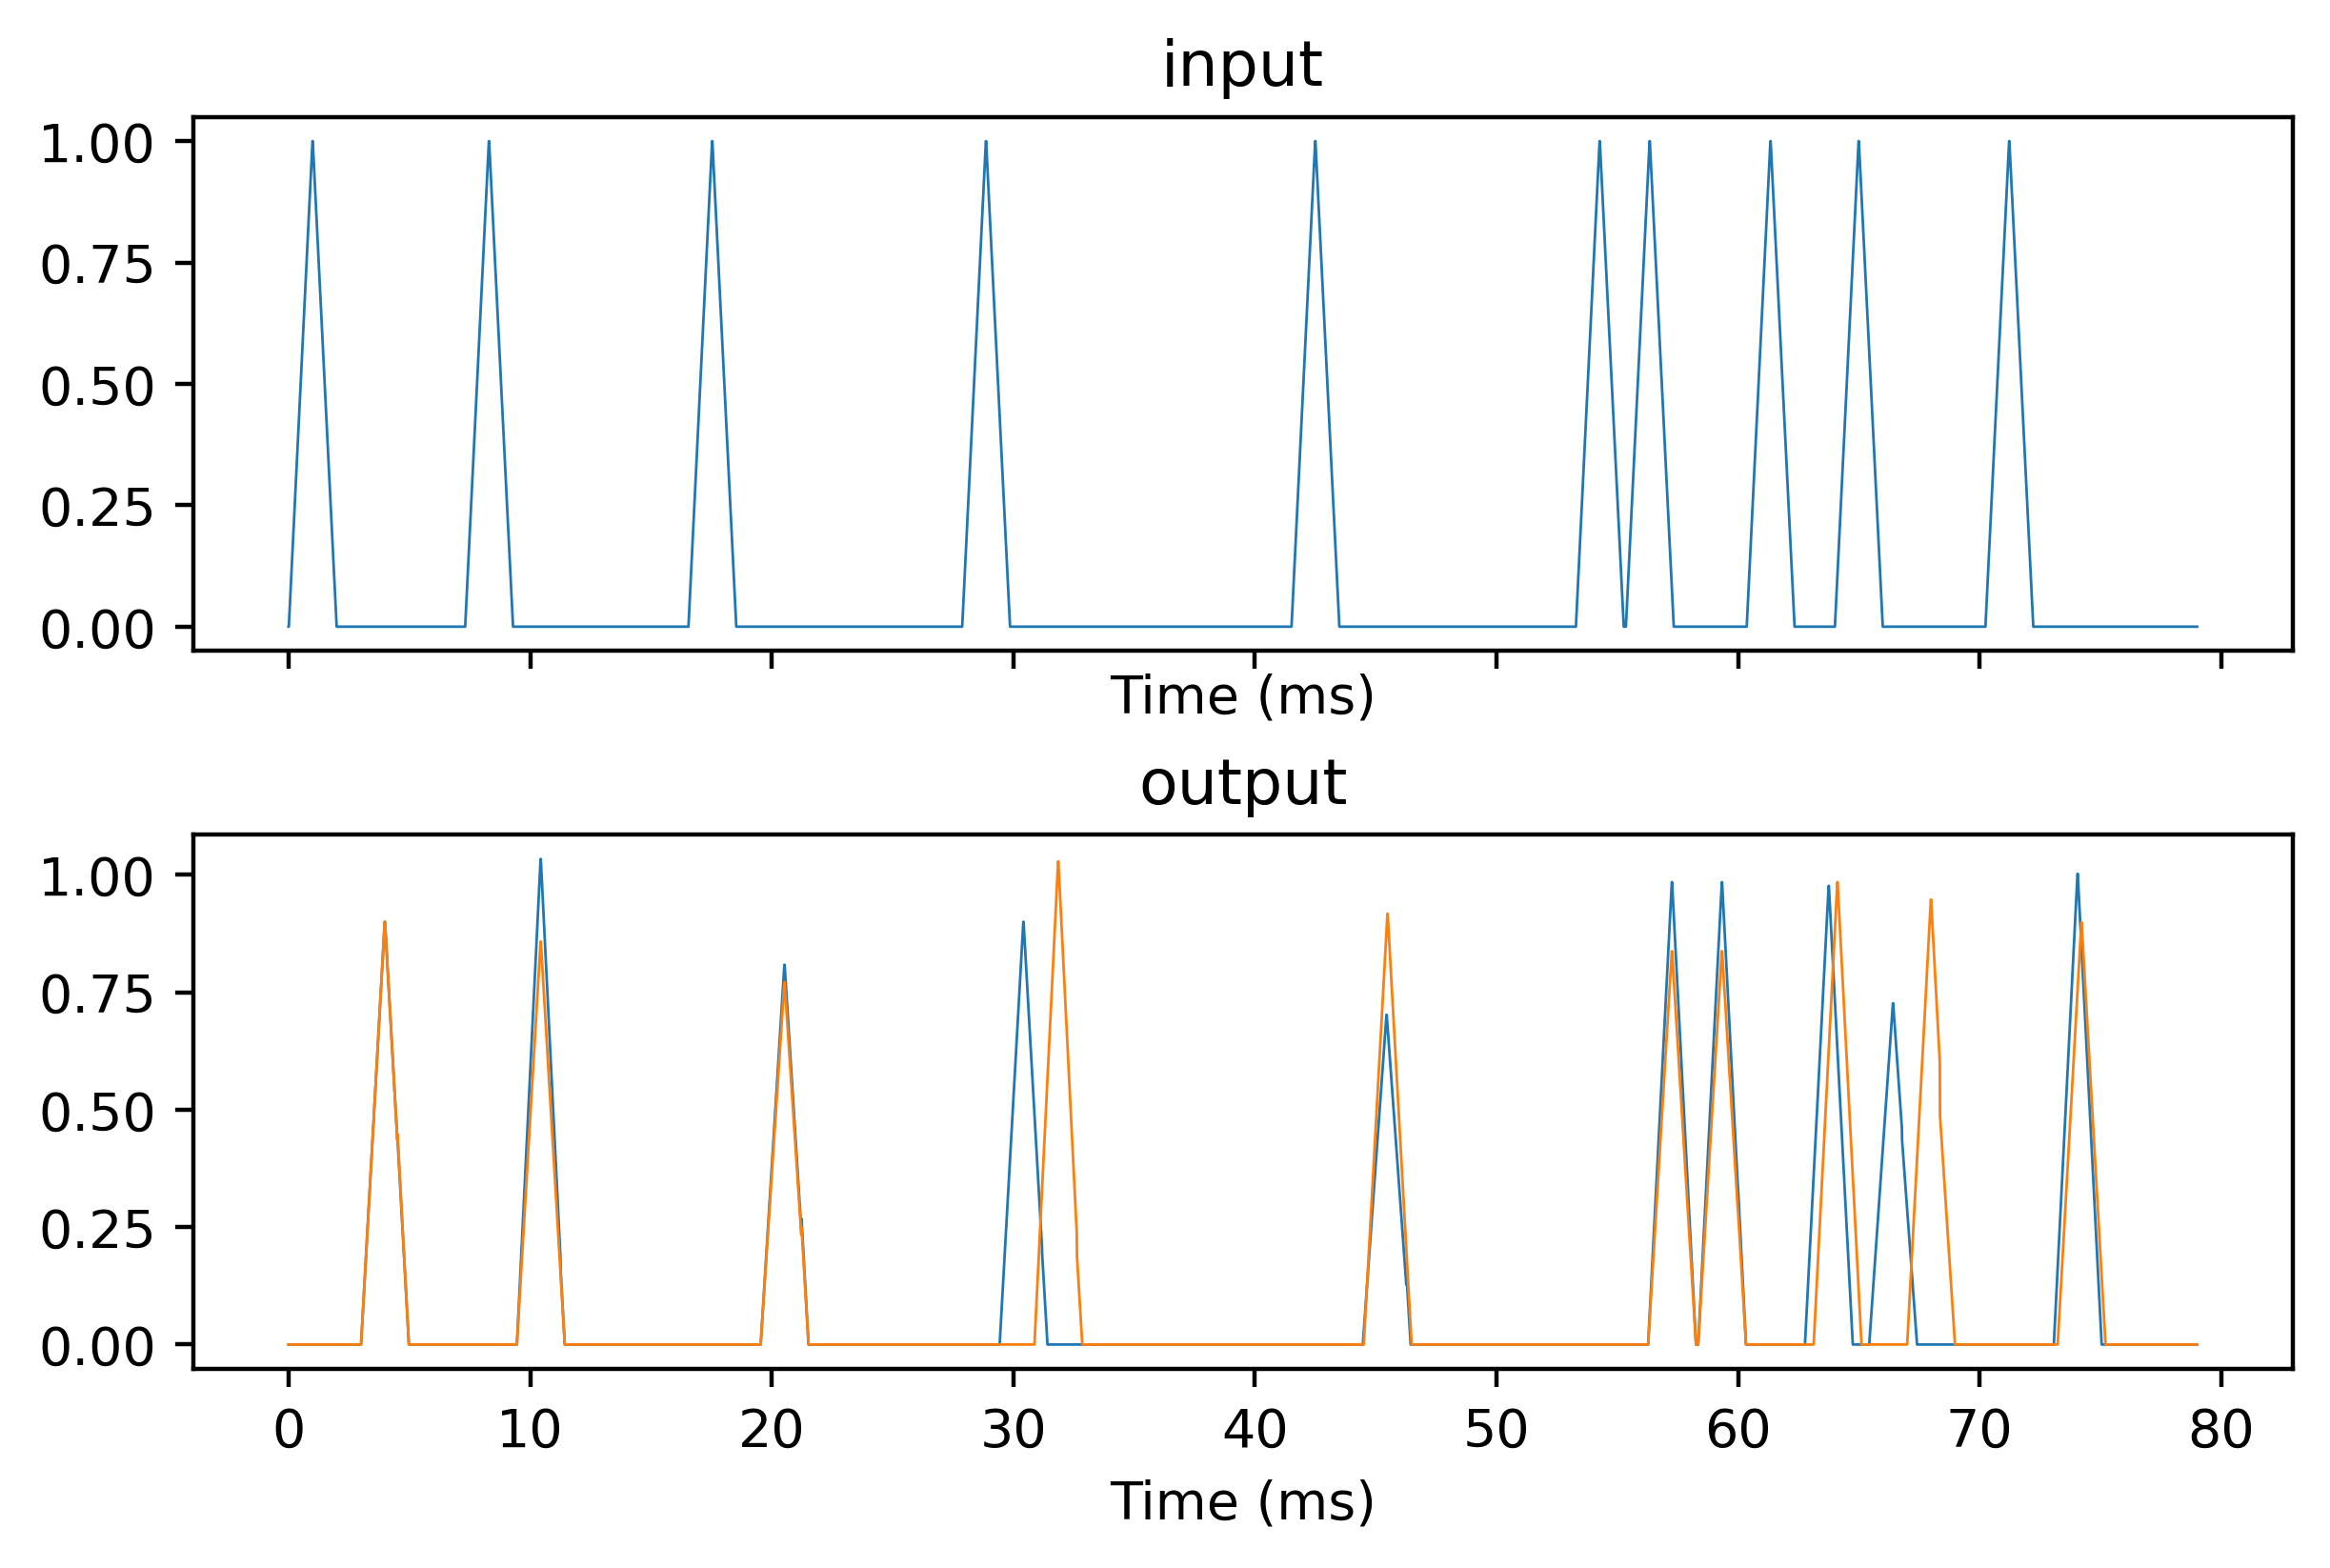

In [3]:

N_t = 10
N_trials = 2
heigth = 1
width=2
time_step = 0.01
bs = 8
std_isi = 5
N_changes = 100
b_delay = 3
b_amp = 0.9
jitter = 1
def trian(heigth=1, width=2, time_step=0.1):
    N = int(width//time_step)
    val = np.zeros(N)
    val[:N//2] = np.linspace(0, heigth, N//2)
    val[N//2:] = np.linspace(heigth, 0, N - N//2)
    return val

train = np.zeros(1)
for i in range(N_t):
    train = np.concatenate((train, trian(heigth=heigth, width=width, time_step=time_step)), axis=0)
    space = np.abs(np.random.normal(bs, std_isi))
    train = np.concatenate((train, np.zeros(int(space/time_step))))

#plt.plot(train)
#plt.show()

tf = train[:(train.size-train.size%N_changes)].reshape((N_changes, train.size//N_changes))
conv_p_time = int(3*jitter/time_step)
y = np.zeros((N_trials, tf.size+conv_p_time))

size_piece = tf.shape[1]
conv_p_time = int(3*jitter/time_step)

interrupted = False
for j in range(N_trials):
    point = 0
    b_delay_steps = int(b_delay/time_step)
    delays = np.zeros(N_changes)
    amp = b_amp
    for i in range(N_changes):
        dirac = np.zeros(conv_p_time)
        delays[i] = np.abs(np.random.normal(b_delay/time_step, jitter/time_step)) if not interrupted else delays[i-1]
        if (tf[i, -1] != 0):
            interrupted = True
        else:
            interrupted = False
        amp = np.random.normal(b_amp*heigth, 0.1*heigth) if not interrupted else amp
        idx = int(delays[i]) if int(delays[i]) < dirac.size else dirac.size - 1
        dirac[idx] = amp
        y_i = np.convolve(dirac, tf[i, :])
        y_i = np.concatenate((np.zeros(point), y_i))
        if (y.shape[1] > y_i.shape[0]):
            y[j, :] += np.concatenate((y_i, np.zeros(y.shape[1]-y_i.shape[0])))
        else:
            y[j, :] += y_i[:y.shape[1]]
        point+= size_piece

if (y.shape[1] > train.size):
    train = np.concatenate((train, np.zeros(y.shape[1]-train.size)))
else:
    y = np.concatenate((y, np.zeros(N_trials, train.size-y.shape[1])), axis=0)

"""y_trasl = np.zeros(y.shape)
avg_del = int(np.mean(delays))
for j in range(N_trials):
    for i in range(y.shape[1] - avg_del):
        y_trasl[j, i] = y[j, i+avg_del]"""
t_axis = np.linspace(0, y.shape[1]*time_step, y.shape[1])
fig, axes = plt.subplots(2, 1, sharex=True, layout="constrained", dpi=400)
myPlot.myPlotFigure(axes[0], t_axis, train, title="input")
axes[0].set_xlabel("Time (ms)")
myPlot.myPlotFigure(axes[1], t_axis, y, title="output", nplots=N_trials)
axes[1].set_xlabel("Time (ms)")

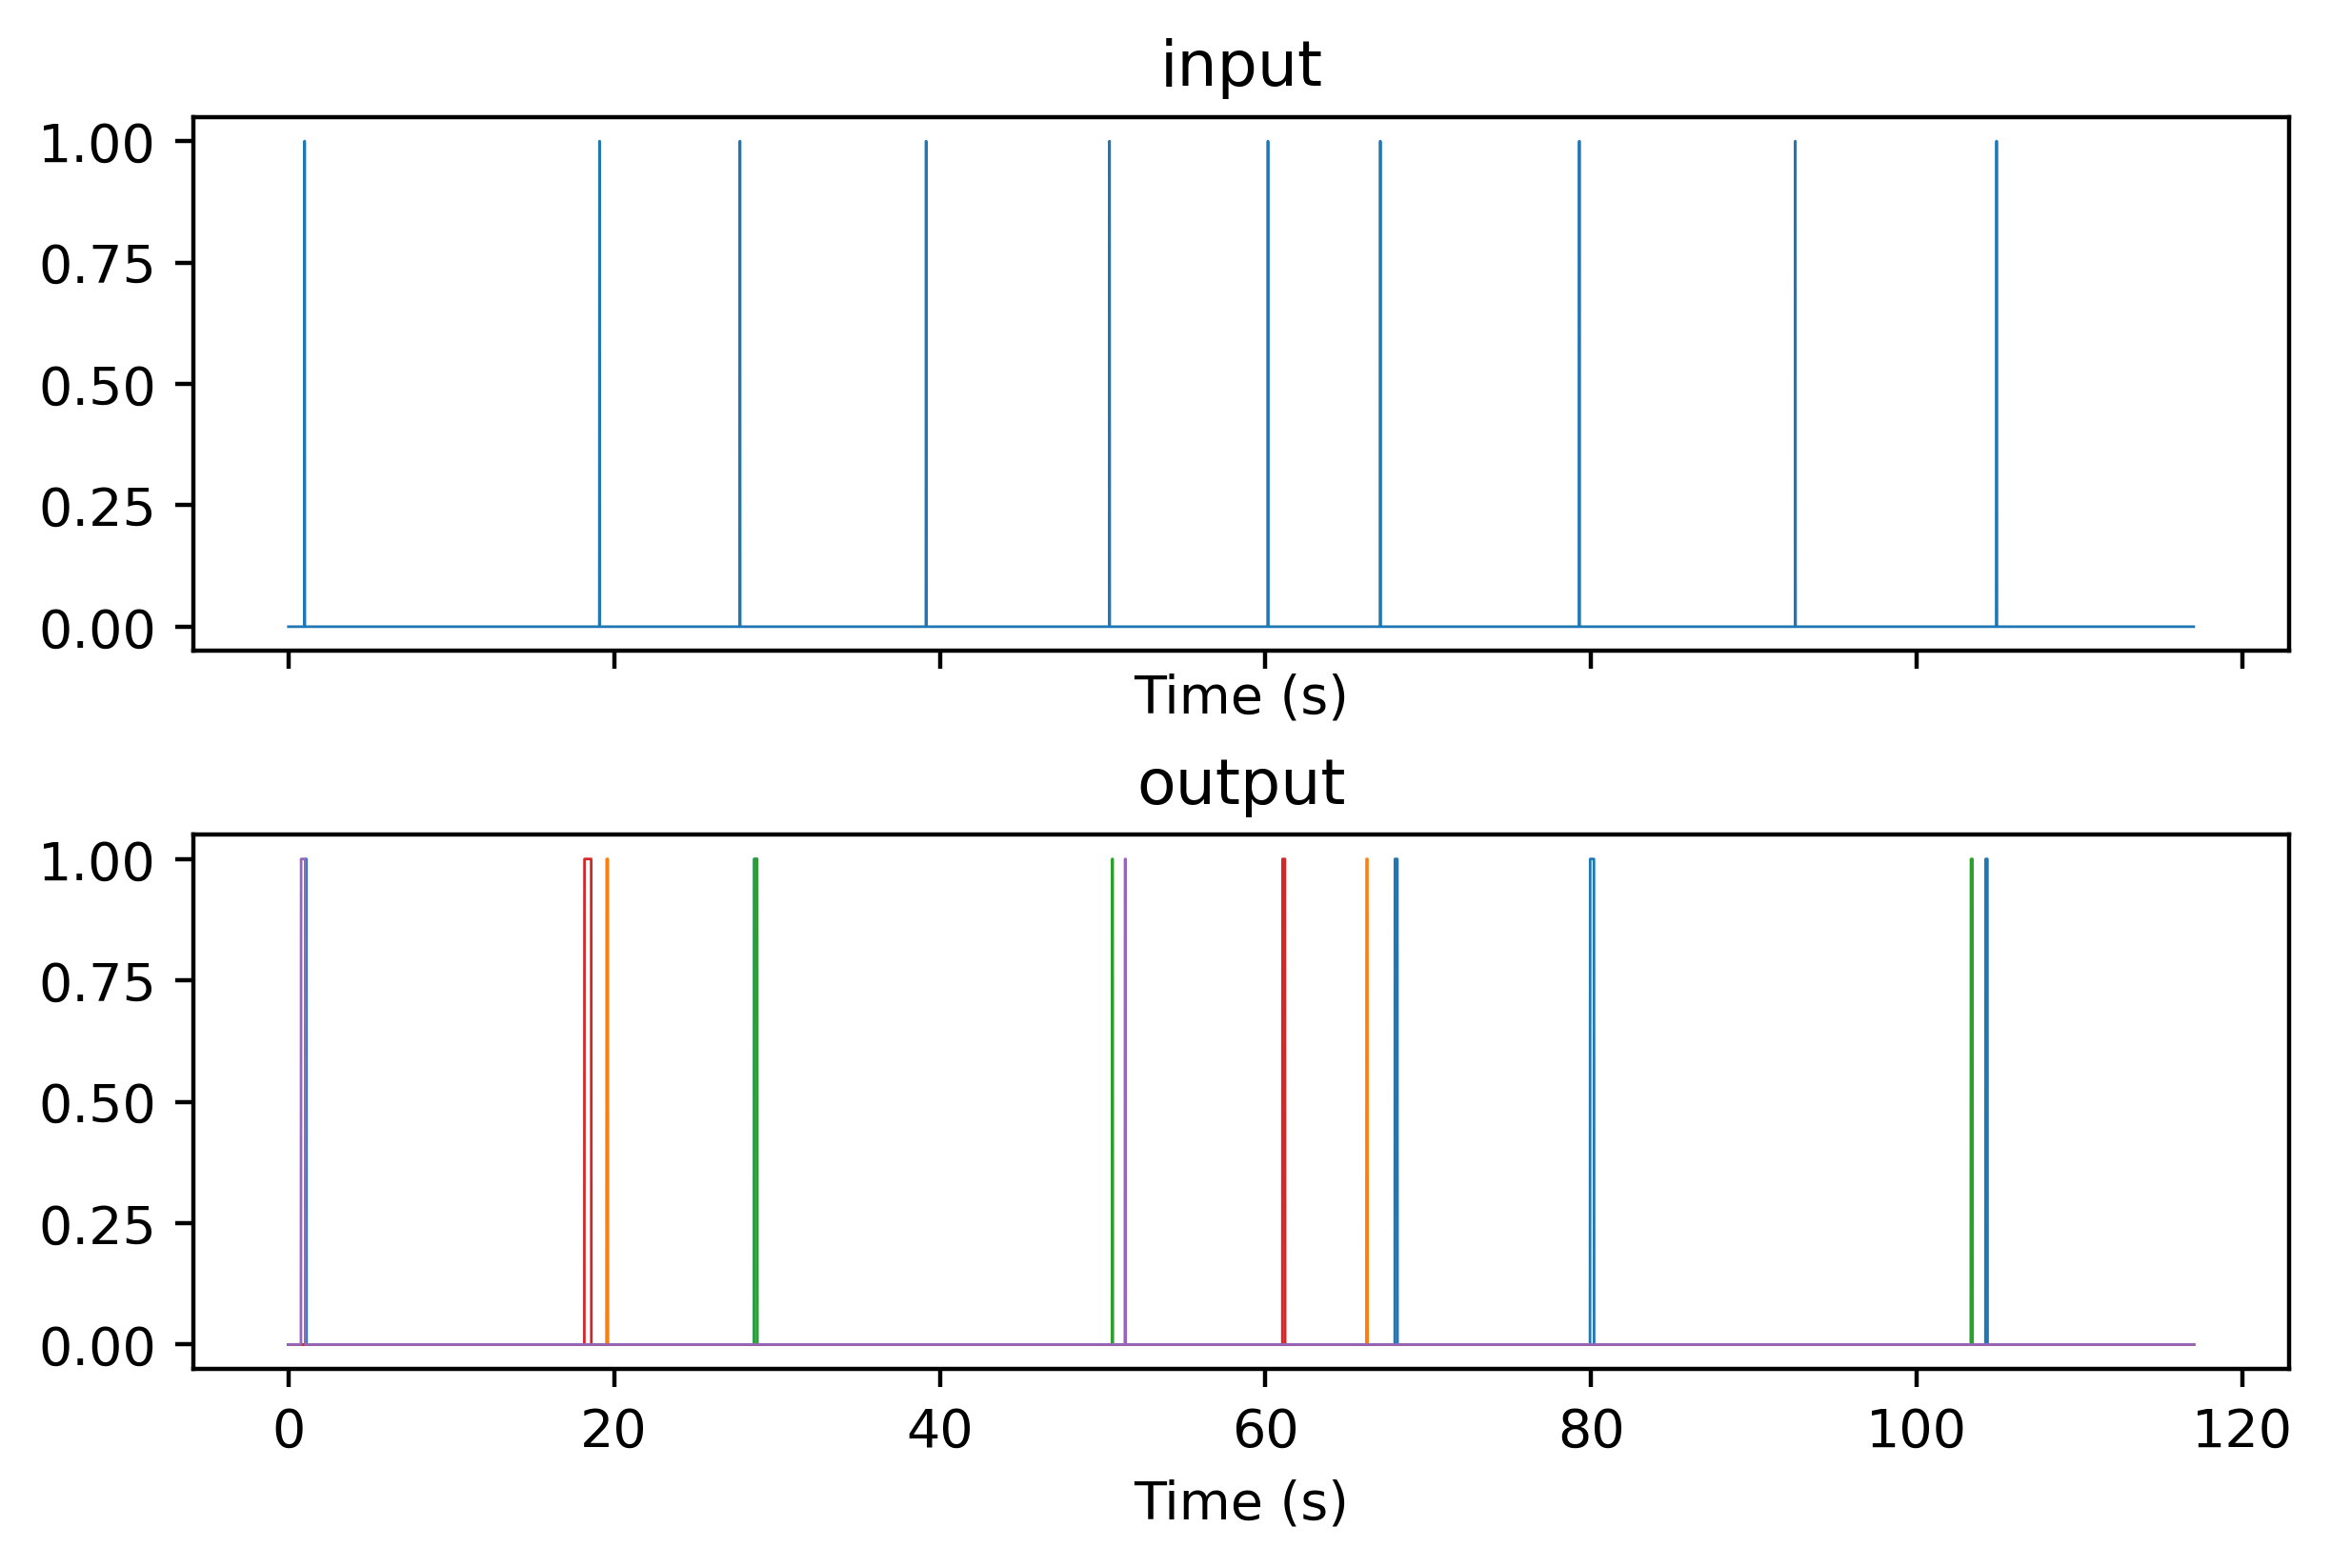

In [107]:
fig, axes = plt.subplots(2, 1, sharex=True, layout="constrained", dpi=400)
myPlot.myPlotFigure(axes[0], t_axis, train==1, title="input")
myPlot.myPlotFigure(axes[1], t_axis, y_trasl>0.96, title="output", nplots=N_trials)